# Lec 16 Lab: Ridge Regression
## CMSE 381 - Spring 20223
## Feb 22, 2023



In this module we are going to test out the ridge regression method we discussed in class from Chapter 6.2.

In [1]:
# Everyone's favorite standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time


# ML imports we've used previously
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# Loading in the data

Ok, here we go, let's play with a baseball data set. 

In [2]:
hitters_df = pd.read_csv('Hitters.csv')
hitters_df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Annoyingly enough we have some missing values in the data. 

In [3]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())


Number of null values: 59


So let's go clean those up.....

In [4]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df = hitters_df.dropna().drop('Player', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df.shape)

# One last check: should return 0
print("Number of null values:", hitters_df["Salary"].isnull().sum())

hitters_df.head()

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


And finally, we can replace our categorical variables with dummy variables.

In [5]:
hitters_df = pd.get_dummies(hitters_df, drop_first = True)
hitters_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [6]:
y = hitters_df.Salary

# Drop the column with the independent variable (Salary)
X = hitters_df.drop(['Salary'], axis = 1).astype('float64')

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    float64
 17  Division_W   263 non-null    float64
 18  NewLeague_N  263 non-null    float64
dtypes: float

# Ridge Regression

In class, we learned that doing ridge regression means that we try to find the best model accoding to the following loss
$$
RSS + \lambda \sum_{i} \beta_i^2.
$$
The good news is that `scikitlearn` has a built in `Ridge` function.  

- [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [User guide](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

In [7]:
from sklearn.linear_model import Ridge

The bad (ok, not honestly that bad) news is that they call their $\lambda$ parameter $\alpha$. So we're just going to minimize 
$$
RSS + \alpha \sum_{i} \beta_i^2.
$$
instead. So if I pick an alpha value, I can do ridge regression as follows.

In [8]:
ridge = Ridge(normalize = True) 

a = 1 #<------ this is me picking an alpha value

ridge.set_params(alpha = a)
ridge.fit(X, y)

print('intercept:', ridge.intercept_)
print('\n')
print(pd.Series(ridge.coef_, index = X.columns))
print('\nTraining MSE:',mean_squared_error(y,ridge.predict(X)))
    


intercept: 26.666878283939695


AtBat           0.097980
Hits            0.767038
HmRun           0.893927
Runs            1.017932
RBI             0.875287
Walks           1.496945
Years           2.030631
CAtBat          0.011288
CHits           0.052696
CHmRun          0.376167
CRuns           0.105102
CRBI            0.110652
CWalks          0.064244
PutOuts         0.146147
Assists         0.022450
Errors         -1.057414
League_N       18.461672
Division_W    -68.848656
NewLeague_N     9.461254
dtype: float64

Training MSE: 110090.38711673138



&#9989; **<font color=red>Q:</font>** What is the `normalize=True` bit doing in the code above?

* Your answer here*

Of course, that was just me picking a random $\alpha$ out of a hat so there's no reason to trust that it's a good one. I could sit here all day and move that $\alpha$ around to see what's going on, but why do that, when I can make a for loop!

Here's a pile of $\alpha$s for us to test on.

In [9]:
alphas = 10**np.linspace(4,-2,100)*0.5
alphas = np.append(alphas,0)
alphas

array([5.00000000e+03, 4.34874501e+03, 3.78231664e+03, 3.28966612e+03,
       2.86118383e+03, 2.48851178e+03, 2.16438064e+03, 1.88246790e+03,
       1.63727458e+03, 1.42401793e+03, 1.23853818e+03, 1.07721735e+03,
       9.36908711e+02, 8.14875417e+02, 7.08737081e+02, 6.16423370e+02,
       5.36133611e+02, 4.66301673e+02, 4.05565415e+02, 3.52740116e+02,
       3.06795364e+02, 2.66834962e+02, 2.32079442e+02, 2.01850863e+02,
       1.75559587e+02, 1.52692775e+02, 1.32804389e+02, 1.15506485e+02,
       1.00461650e+02, 8.73764200e+01, 7.59955541e+01, 6.60970574e+01,
       5.74878498e+01, 5.00000000e+01, 4.34874501e+01, 3.78231664e+01,
       3.28966612e+01, 2.86118383e+01, 2.48851178e+01, 2.16438064e+01,
       1.88246790e+01, 1.63727458e+01, 1.42401793e+01, 1.23853818e+01,
       1.07721735e+01, 9.36908711e+00, 8.14875417e+00, 7.08737081e+00,
       6.16423370e+00, 5.36133611e+00, 4.66301673e+00, 4.05565415e+00,
       3.52740116e+00, 3.06795364e+00, 2.66834962e+00, 2.32079442e+00,
      

First off, let's take a look at how the coefficients learned change for various choices of $\alpha$. 

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a  19×100  matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). 



In [10]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(101, 19)

First off, let's take a look at how the coefficients learned change for various choices of $\alpha$. 

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix coefs. In this case, it is a  19×100  matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). 

Text(0, 0.5, 'weights')

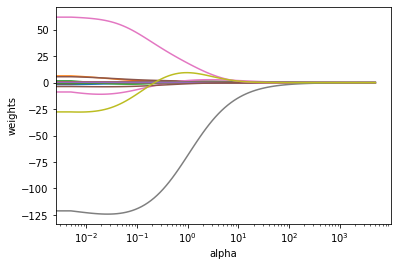

In [11]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


&#9989; **<font color=red>Q:</font>** There are two variables that have higher magnitude than the rest for low $\alpha$s (read: are either very large positive or very large negative). Which two are they from the data set? Which is which?


In [ ]:
# Your code here #

Now we can start setting up the usual train/test splits to have at least a starting idea of how the testing error is going. The `random_state=1` bit just makes it so that everyone should get the same random split. 

In [ ]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


&#9989; **<font color=red>Do this:</font>** Train a model using ridge regression with $\alpha = 4$. What is the MSE of your model on the testing set?

In [ ]:
# Your code here #


&#9989; **<font color=red>Do this:</font>** Ha ha nah, you can do better than that.  Lets try all our alphas and take a look at the testing MSE to make a better decision about what $\alpha$ we might want. Modify the code below to plot your testing MSE for all the alphas. What $\alpha$ should we use to train the model?

In [ ]:
# Modify your code from above and add it in the for loop to plot the testing MSE

ridge = Ridge(normalize = True)
errors = []

for a in alphas:
    # ==== Your code goes in here ==== #
    errors.append(17) #<----- random number in here so that the code runs before you fix it
    
np.shape(errors)

plt.plot(alphas,errors)
plt.title('Testing MSE')
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')



## RidgeCV

Whelp, your meanie professor didn't tell you that there's actually a built in function to do this for you (sorry-not-sorry). Aren't you glad you didn't read ahead?


In [ ]:
from sklearn.linear_model import RidgeCV

- [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

Basically, `RidgeCV` runs LOOCV (unless you tell it otherwise, see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)) on all the alpha values you specify on an input array, and tells you the best $\alpha$ given that. 

In [ ]:
# I'm going to drop that 0 from the alphas because it makes 
# RidgeCV cranky
alphas = alphas[:-1]


ridgecv = RidgeCV(alphas = alphas, 
                  scoring = 'neg_mean_squared_error', 
                  normalize = True)
ridgecv.fit(X_train, y_train)
print('alpha chosen is', ridgecv.alpha_)

I can predict my values on the test set directly from the `ridgecv` model we just built. 

In [ ]:
pred = ridgecv.predict(X_test)
mean_squared_error(y_test,pred)

This is exactly the same result as if I went and retrained my model using the chosen $\alpha$ using `Ridge`. 

In [ ]:
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, y_train)
mean_squared_error(y_test, ridge.predict(X_test))

&#9989; **<font color=red>Do this:</font>** Why did we get a different best choice of $\alpha$ than we found in the previous section? 

*Your answer here*



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.